**AdventureWorks Custom Vision Model**
                                          
In this tutorial, we will be training a custom vision models for AdventureWorks retailers. Using Python 3.8 - Pytorch and Tensorflow. Let's first upgrade the tensorflow package.

In [95]:
!pip install --upgrade tensorflow

  Using cached https://files.pythonhosted.org/packages/d3/59/d88fe8c58ffb66aca21d03c0e290cd68327cc133591130c674985e98a482/tensorflow-1.14.0-cp27-cp27mu-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/05/d2/f94e68be6b17f46d2c353564da56e6fb89ef09faeeff3313a046cb810ca9/mock-3.0.5-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/79/9c/f5d1209c8e4e091e250eb3ed099056e7e1ad0ec1e9ca46f6d88389e2d6d4/wrapt-1.14.1-cp27-cp27mu-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/74/4e/9f3cb458266ef5cdeaa1e72a90b9eda100e3d1803cbd7ec02f0846da83c3/protobuf-3.18.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/79/4c/7c3275a01e12ef9368a892926ab932b33bb13d55794881e3573482b378a7/Keras_Preprocessing-1.1.2-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/6f/2c/a9386903ece2ea85e9807e0e062174dc26fdce8b05f216d00491be29fad5/enum34-1.1.10-py2-none-any.whl
  Using cached https:/

**importing libraries for building custom vision model**

In [96]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [97]:
print(tf.__version__)

2.8.0


**Download and unzip the sample images**

In [98]:
import pathlib
dataset_url = "https://github.com/rawatsudhir1/DeepLearningDemoFiles/tree/main/zip_images/gear_images.zip"
data_dir = tf.keras.utils.get_file('gear_images', origin=dataset_url, extract=True, archive_format='zip', cache_dir="cache/")
data_dir = pathlib.Path(data_dir)
print (data_dir)

cache/datasets/gear_images


In [99]:
image_count = len(list(data_dir.glob('*/*.jpeg')))
print(image_count)

1734


In [100]:
batch_size = 32
img_height = 180
img_width = 180

**80 % for training and 20 % for testing** 

In [101]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2129 files belonging to 12 classes.
Using 1704 files for training.


In [102]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2129 files belonging to 12 classes.
Using 425 files for validation.


In [103]:
class_names = train_ds.class_names
print(class_names)

['axes', 'boots', 'carabiners', 'crampons', 'gloves', 'hardshell_jackets', 'harnesses', 'helmets', 'insulated_jackets', 'pulleys', 'rope', 'tents']


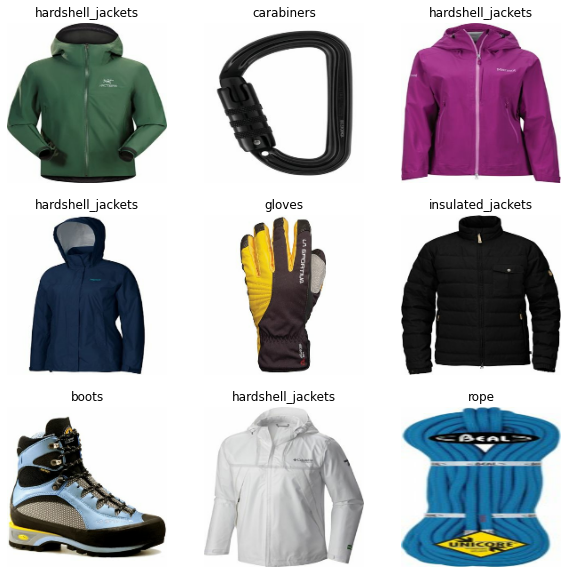

In [104]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

**image_batch is a tensor of the shape (32, 180, 180, 3) :- 32 images witrh shape of 180 X 180 with color channel RGB and (32,) refers to labels to the 32 images**

In [105]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


**Cache :- transformation can cache a dataset, either in memory or on local storage. This will save some operations (like file opening and data reading) from being executed during each epoch.**

**Prefetching overlaps the preprocessing and model execution of a training step. While the model is executing training step s, the input pipeline is reading the data for step s+1. Doing so reduces the step time to the maximum (as opposed to the sum) of the training and the time it takes to extract the data.**


In [106]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [107]:
normalization_layer = layers.Rescaling(1./255)

In [108]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


**Sequential model -> plain stack of layers. One input tensor and one output tensor**

Layer Rescaling :- preprocessing layer which rescales input values to a new range

3 convolution blocks (tf.keras.layers.Conv2D) with a max pooling layer (tf.keras.layers.MaxPooling2D) in each of them. There's a fully-connected layer (tf.keras.layers.Dense) with 128 units on top of it that is activated by a ReLU activation function ('relu')


In [109]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [110]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [111]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_11 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 45, 45, 64)       

In [112]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
54/54 [==============================] - 39s 721ms/step - loss: 1.5604 - accuracy: 0.4883 - val_loss: 0.8091 - val_accuracy: 0.7482
Epoch 2/10
54/54 [==============================] - 28s 524ms/step - loss: 0.5309 - accuracy: 0.8322 - val_loss: 0.5662 - val_accuracy: 0.8376
Epoch 3/10
54/54 [==============================] - 29s 529ms/step - loss: 0.2364 - accuracy: 0.9243 - val_loss: 0.5299 - val_accuracy: 0.8353
Epoch 4/10
54/54 [==============================] - 28s 527ms/step - loss: 0.1224 - accuracy: 0.9619 - val_loss: 0.4318 - val_accuracy: 0.8918
Epoch 5/10
54/54 [==============================] - 28s 527ms/step - loss: 0.0647 - accuracy: 0.9800 - val_loss: 0.4977 - val_accuracy: 0.8824
Epoch 6/10
54/54 [==============================] - 28s 525ms/step - loss: 0.0560 - accuracy: 0.9812 - val_loss: 0.5412 - val_accuracy: 0.8776
Epoch 7/10
54/54 [==============================] - 28s 526ms/step - loss: 0.0228 - accuracy: 0.9947 - val_loss: 0.5616 - val_accuracy: 0.8941

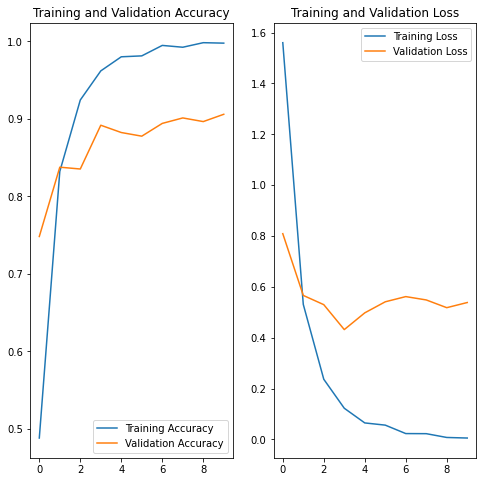

In [113]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

24576/11913 [=============================================================] - 0s 0us/step
This image most likely belongs to harnesses with a 100.00 percent confidence.


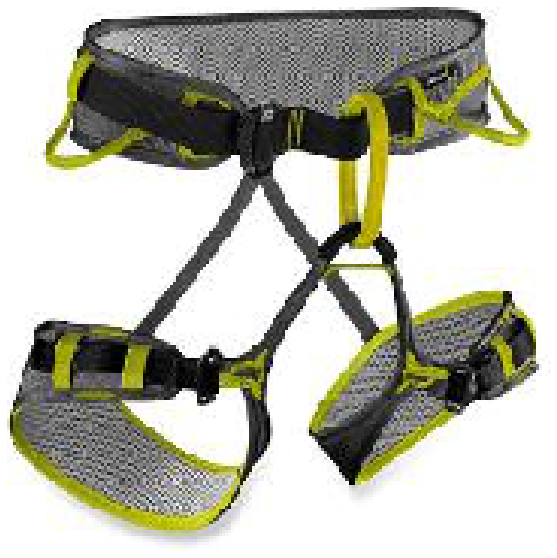

In [115]:
import matplotlib.pyplot as plt1

image_url = "https://sudhirawdeeple7205538429.blob.core.windows.net/testimages/100525.jpeg"
image_path = tf.keras.utils.get_file('image_chck1', origin=image_url, cache_dir="testcache1/" )

img = tf.keras.utils.load_img(image_path, target_size=(img_height, img_width))

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

plt1.figure(figsize=(10, 10))
plt1.imshow(img)
plt1.axis("off")
tf.io.gfile.remove(image_path)